In [3]:
import os
import openai
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

openai.api_key = os.environ['OPENAI_API_KEY']


def get_embedding(text):
    '''Compute GPT3-embedding for a given text string'''
    result = openai.Embedding.create(input=text, model='text-embedding-ada-002')
    return result.data[0].embedding

In [4]:
people = [
    'middle-aged white man who likes outdise activities',
    'young black woman who enjoyes staying inside and read books',
    'old hispanic man who likes sports and active lifestyle',
    ]

messages = [
    'take a break and read a book',
    'go take a walk in a park',
    'ride a bike or swim in a pool',
    ]

images = [
    'a picture of a young man riding a bike',
    'an image of a books and a tea cup',
    'an illustration of a park with trees and shit',
    ]

In [5]:
df = pd.DataFrame(people + messages + images, columns=['content'])
df['embedding'] = df['content'].apply(get_embedding)
df

,content,embedding
0,middle-aged white man who likes outdise activi...,"[-0.00290665146894753, -0.01847919635474682, 0..."
1,young black woman who enjoyes staying inside a...,"[-0.008273256942629814, -0.018472354859113693,..."
2,old hispanic man who likes sports and active l...,"[-0.01603090949356556, 0.0036470319610089064, ..."
3,take a break and read a book,"[-0.006369683425873518, -0.020342404022812843,..."
4,go take a walk in a park,"[0.008950120769441128, -0.0046096970327198505,..."
5,ride a bike or swim in a pool,"[0.009990998543798923, 0.0008240493480116129, ..."
6,a picture of a young man riding a bike,"[-0.005093972664326429, -0.009724857285618782,..."
7,an image of a books and a tea cup,"[-0.009359859861433506, -0.013218122534453869,..."
8,an illustration of a park with trees and shit,"[-0.0023086960427463055, -0.008225834928452969..."


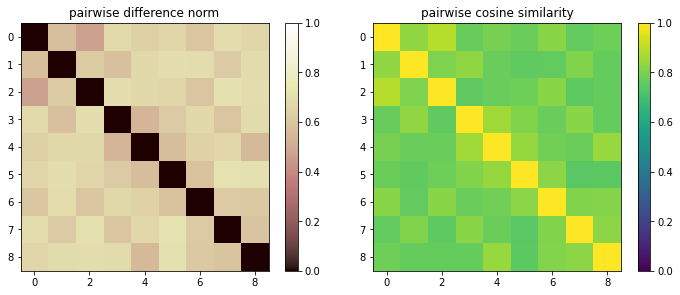

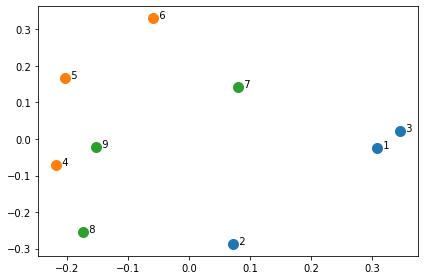

In [10]:
fig, ax = plt.subplots(1, 2, figsize=(10,4))

# embeeding difference norm
emb_norm_diff = np.array([[np.linalg.norm(np.array(e1)-np.array(e2))\
                           for e2 in df['embedding']] for e1 in df['embedding']])
im0 = ax[0].imshow(emb_norm_diff, cmap='pink', vmin=0., vmax=1.)
ax[0].set_title('pairwise difference norm')
ax[0].grid(False)
plt.colorbar(im0, ax=ax[0])

# embedding cosine similarity
emb_cossim = np.array([[np.dot(e1,e2) for e2 in df['embedding']] for e1 in df['embedding']])
im1 = ax[1].imshow(emb_cossim, cmap='viridis', vmin=0., vmax=1.)
ax[1].set_title('pairwise cosine similarity')
ax[1].grid(False)
plt.colorbar(im1, ax=ax[1])

plt.tight_layout()
plt.show()


# embedding pca
emb = df['embedding'].tolist()
emb_pca = PCA(n_components=2).fit_transform(emb)
emb_person, emb_message, emb_image = np.split(emb_pca, [len(people),-len(images)])
fig, ax = plt.subplots(figsize=(6,4))
ax.scatter(emb_person[:,0], emb_person[:,1], s=100)
ax.scatter(emb_message[:,0], emb_message[:,1], s=100)
ax.scatter(emb_image[:,0], emb_image[:,1], s=100)
for i in range(len(df)):
    ax.annotate(f'  {i+1}', emb_pca[i])
plt.tight_layout()
plt.show()

In [11]:
embs = np.split(df['embedding'].tolist(), [len(people),-len(images)])
for emb in embs:
    emb -= emb.mean(axis=0)
df['embedding2'] = list(np.concatenate(embs))

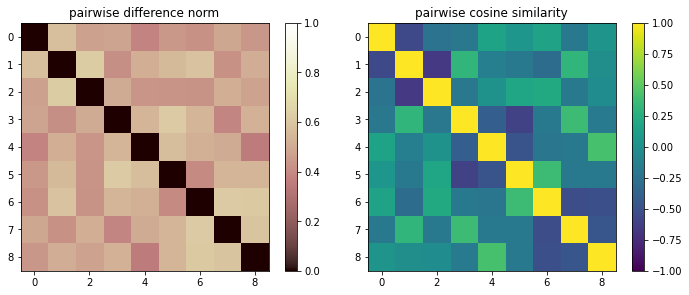

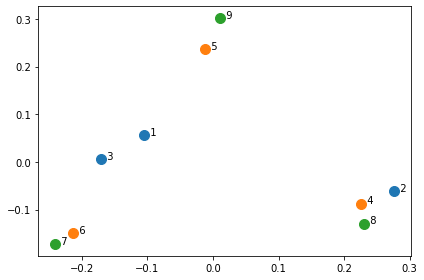

In [14]:
fig, ax = plt.subplots(1, 2, figsize=(10,4))

# embeeding difference norm
emb_norm_diff = np.array([[np.linalg.norm(np.array(e1)-np.array(e2)) for e2 in df['embedding2']] for e1 in df['embedding2']])
im0 = ax[0].imshow(emb_norm_diff, cmap='pink', vmin=0., vmax=1.)
ax[0].set_title('pairwise difference norm')
ax[0].grid(False)
plt.colorbar(im0, ax=ax[0])

# embedding cosine similarity
emb_cossim = np.array([[np.dot(e1,e2) / (np.linalg.norm(e1) * np.linalg.norm(e2)) for e2 in df['embedding2']] for e1 in df['embedding2']])
im1 = ax[1].imshow(emb_cossim, cmap='viridis', vmin=-1., vmax=1.)
ax[1].set_title('pairwise cosine similarity')
ax[1].grid(False)
plt.colorbar(im1, ax=ax[1])

plt.tight_layout()
plt.show()


# embedding pca
emb = df['embedding2'].tolist()
emb_pca = PCA(n_components=2).fit_transform(emb)
emb_person, emb_message, emb_image = np.split(emb_pca, [len(people),-len(images)])
fig, ax = plt.subplots(figsize=(6,4))
ax.scatter(emb_person[:,0], emb_person[:,1], s=100)
ax.scatter(emb_message[:,0], emb_message[:,1], s=100)
ax.scatter(emb_image[:,0], emb_image[:,1], s=100)
for i in range(len(df)):
    ax.annotate(f'  {i+1}', emb_pca[i])
plt.tight_layout()
plt.show()